In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

RAND_INIT = 1234

In [30]:
def norm_X(df):
    real_X = df.iloc[:, 4:].as_matrix().astype(float)
    
    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std
        
    return real_X

def tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    return real_X

def norm_tfidf_X(df):
    real_X = df.iloc[:, 4:].as_matrix()
    trf = TfidfTransformer()
    real_X = trf.fit_transform(real_X).toarray()

    for i in xrange(real_X.shape[1]):
        col = real_X[:,i]
        col_std = np.std(col)
        col_mean = np.mean(col)
        real_X[:,i] = (col - col_mean) / col_std

    return real_X

In [15]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
real_X = norm_X(df_sns)

In [27]:
real_X = np.concatenate((real_X[:14187], real_X[14188:]))
df_sns = df_sns.drop(df_sns.index[14187])

In [28]:
kmeans = KMeans(n_clusters=9, random_state=RAND_INIT, max_iter=100)
kmeans.fit(real_X)

represent = df_sns.iloc[:, :4]
represent['cluster'] = kmeans.labels_
represent.groupby('cluster').agg({'cluster':{'size': len}})

,cluster
,size
cluster,
0,2064
1,2502
2,12528
3,3290
4,1939
5,1701
6,2563
7,1463


In [31]:
df_clusters = df_sns.copy()
df_clusters['cluster'] = kmeans.labels_

In [7]:
interests = df_clusters.columns[4:-1]
aggs = {key : np.sum for key in interests}
aggs['cluster'] = {'size': len}

res = df_clusters.groupby('cluster').agg(aggs)
res.columns = res.columns.get_level_values(0)

# res

for interest in interests:
    res[interest] = res[interest] / res['cluster'] * 100000
    col_std = np.std(res[interest])
    col_mean = np.mean(res[interest])
    res[interest] = (res[interest] - col_mean) / col_std

#     res[interest] = res[interest] / np.sum(res[interest]) / res['cluster'] * 100000
    
from IPython import display
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display.display(res)

,cute,drunk,dance,sex,hair,cluster,church,blonde,kissed,dress,marching,basketball,god,tennis,sports,hot,music,abercrombie,soccer,shopping,drugs,football,cheerleading,band,death,baseball,softball,sexy,jesus,bible,die,volleyball,mall,rock,hollister,clothes,swimming
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.697124,-0.471649,-0.811135,-0.377642,-0.462987,2305,-0.293645,-0.053797,-0.406511,-0.496144,-0.367121,2.640724,-0.399833,0.904454,2.167947,-0.720310,-0.542546,-0.407264,2.435869,-0.745614,-0.408430,2.565671,-0.372598,-0.431895,-0.660006,2.703906,2.772230,-0.519292,-0.350401,-0.357882,-0.533878,2.726851,-0.684692,-0.236583,-0.402322,-0.678185,-0.394266
1,2.057198,-0.264057,1.849042,-0.319765,-0.061560,3992,0.069102,-0.302028,-0.338956,-0.496181,-0.376311,-0.532732,-0.301787,0.353726,-0.536272,1.927854,0.137540,-0.373092,0.250343,1.709452,-0.366187,-0.555256,-0.379151,-0.381068,-0.242974,-0.509432,-0.517577,1.403525,-0.330697,-0.374078,-0.265947,-0.435017,1.531333,-0.167202,-0.351444,0.848094,2.034426
2,0.527395,-0.240518,0.226517,-0.287014,0.086587,830,-0.509624,0.392790,-0.252616,-0.238566,-0.365938,-0.119801,-0.405105,1.405599,-0.164350,1.070252,-0.317860,2.812341,0.168869,1.427151,-0.270120,-0.083822,-0.213612,-0.445251,-0.258923,-0.290409,-0.285458,0.080019,-0.344162,-0.364877,-0.314048,0.155646,1.128602,-0.363438,2.817754,0.744350,0.766821
3,-0.103141,-0.264102,0.444226,-0.331933,-0.278723,1654,-0.361788,-0.713477,-0.332127,2.780559,-0.364505,-0.547646,-0.391417,-0.412726,-0.659681,-0.621805,-0.468209,-0.398313,-0.435657,-0.061527,-0.366228,-0.615272,-0.375526,-0.381788,-0.358197,-0.561697,-0.418904,-0.356967,-0.362364,-0.364788,-0.347481,-0.449317,-0.267818,-0.480911,-0.382666,-0.379971,-0.809035
4,-1.313032,-0.493897,-1.434112,-0.470991,-0.726375,18563,-0.720104,-1.047851,-0.452693,-0.586456,-0.383434,-0.855398,-0.512279,-1.311588,-0.727178,-1.276122,-1.079855,-0.438942,-1.095348,-1.377123,-0.431271,-1.022141,-0.416047,-0.473598,-0.838975,-0.650283,-0.669495,-1.019248,-0.405010,-0.374024,-0.569882,-0.740964,-1.258535,-0.875788,-0.437901,-1.102212,-1.430818
5,0.964387,2.812738,1.202794,2.824499,2.752998,896,-0.194326,2.441795,2.823813,0.083054,-0.304999,0.375582,-0.066312,1.356856,1.477017,0.722589,2.539243,-0.085454,0.465651,-0.034568,2.823835,0.337128,-0.285317,0.017760,2.496016,0.325735,0.049505,2.058694,-0.295001,-0.289006,2.764299,-0.042573,1.288359,2.761727,-0.181996,2.219993,0.952154
6,0.180206,-0.380739,0.019904,-0.318043,-0.340610,634,-0.303937,0.558840,-0.285839,-0.300482,-0.359260,-0.070726,-0.361874,-1.348621,-0.418687,0.274501,-0.768317,-0.265275,-0.433394,0.611467,-0.341095,0.329239,2.823240,-0.445153,-0.535163,-0.039649,-0.156001,-0.026884,-0.371032,-0.352742,-0.483992,-0.170685,0.042823,-0.335998,-0.220162,-0.359018,-0.383515
7,-0.784993,-0.214008,-0.906436,-0.319294,-0.438666,384,2.768319,-0.471618,-0.385011,-0.370780,-0.305833,-0.166896,2.809989,-0.271835,-0.479576,-0.517493,0.113408,-0.406021,-0.316717,-0.622404,-0.247813,-0.471532,-0.373049,-0.258088,0.909865,-0.387658,-0.300237,-0.945690,2.827279,2.827595,0.186509,-0.412310,-0.816534,-0.142763,-0.395731,-0.562134,-0.153971
8,-0.830896,-0.483767,-0.590800,-0.399817,-0.530665,741,-0.453997,-0.804655,-0.370059,-0.375004,2.827400,-0.723107,-0.371382,-0.675865,-0.659220,-0.859465,0.386596,-0.437980,-1.039616,-0.906834,-0.392691,-0.484015,-0.407940,2.799082,-0.511643,-0.590514,-0.474063,-0.674156,-0.368612,-0.350199,-0.435580,-0.631632,-0.963539,-0.159044,-0.445532,-0.730915,-0.581796


In [32]:
for i, row in enumerate(res.as_matrix().argsort(axis=1)):
    top_inds = row[::-1][1:6]
    print('{} : {}'.format(i, ' '.join(res.columns[top_inds])))

0 : softball volleyball baseball basketball football
1 : cute swimming hot dance shopping
2 : hollister abercrombie shopping tennis mall
3 : dress dance shopping cute drunk
4 : bible marching jesus cheerleading drugs
5 : sex drugs kissed drunk die
6 : cheerleading shopping blonde football hot
7 : bible jesus god church death
8 : marching band music rock bible


In [33]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import gc
from sklearn.utils import shuffle

def quality(x, y):
    x, y = shuffle(x, y, random_state=RAND_INIT)    
    x = x[:1000]
    y = y[:1000]
    gc.collect()
    
    n, d = x.shape
    k = y.max() + 1
    classmasks = np.empty((k, n), dtype=bool)
    means = np.empty(n, k)
    
    dists = squareform(pdist(x))
    gc.collect()

        
    classmasks = np.array(xrange(k))[:, None] == y
    gc.collect()

    class_dists = np.array([dists[:,classmasks[i]].mean(axis=1) for i in xrange(k)])
    dists = None
    gc.collect()
    
    a_x = (class_dists * classmasks).max(axis=0)
    gc.collect()
    
    max_val = class_dists.max()
    gc.collect()
    b_x = (class_dists + (classmasks * max_val)).min(axis=0)
    
    class_dists = None
    gc.collect()
    
    sil_x = (b_x - a_x) / np.amax((a_x, b_x), axis=0)
    a_x = None
    b_x = None
    gc.collect()
    
    return sil_x.mean()

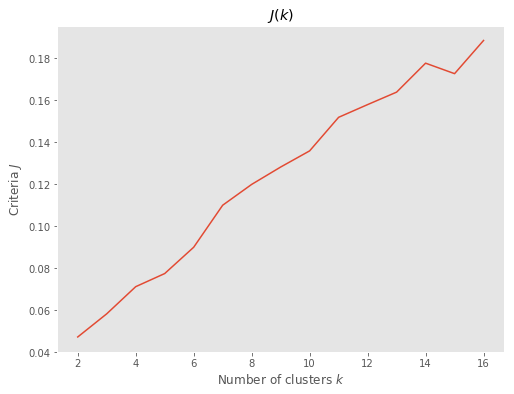

In [39]:
# from sklearn.mixture import GaussianMixture
ks = range(2, 17)
criteria = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = KMeans(n_clusters=k, random_state=RAND_INIT, max_iter=100)
    try:
        y = cls.fit(real_X).labels_
#         y = cls.predict(x)
        criteria[i] = quality(real_X, y)
    except Exception as e:
        print 'oops'
        print k
        raise e
    
plt.figure(figsize=(8, 6))
plt.plot(ks, criteria)
plt.title("$J(k)$")
plt.ylabel("Criteria $J$")
plt.xlabel("Number of clusters $k$")
plt.grid()
plt.show()

In [18]:
# normilized
# from sklearn.metrics import silhouette_score
# silhouette_score(real_X, kmeans.labels_)
%time quality(real_X, kmeans.labels_)

CPU times: user 6.51 s, sys: 819 ms, total: 7.33 s
Wall time: 7.35 s


0.19731772479319534

In [29]:
# tf.idf
# from sklearn.metrics import silhouette_score
# silhouette_score(real_X, kmeans.labels_)
%time quality(real_X, kmeans.labels_)

CPU times: user 6.64 s, sys: 767 ms, total: 7.41 s
Wall time: 7.44 s


0.12669403081173014

In [81]:
# normilized tf.idf
# from sklearn.metrics import silhouette_score
# silhouette_score(real_X, kmeans.labels_)
%time quality(real_X, kmeans.labels_)

CPU times: user 7.17 s, sys: 888 ms, total: 8.06 s
Wall time: 8.11 s


0.05269691015032827

In [42]:
with open('idf.data', 'w') as f:
    np.save(f, real_X)
with open('idf.labels', 'w') as f:
    np.save(f, kmeans.labels_)  

## Вывод

### Kmeans
Модификации имеют свои преимущества и недостатки.

MiniBatch дает ощутимый выигрыш по времени, однако точность несколько падает.

KMeans++ позволяет защититься от ситуации, когда два центроида оказываются случайно выбраны слишком близко друг к другу. Тем не менее, при большом числе точек время кластеризации ощутимо растет.

Таким образом, ни одну из модификаций алгоритма нельзя считать лучшей. Выбор должен определяться обстоятельствами.

### Интерпретация реальных данных

Исследовав результаты кластеризации обычным Kmeans с косинусной метрикой, я обнаружил следующие кластеры

1. Интересующиеся танцами и магазинами, которым нравится все симпатичное и сексуальное
1. Маргинальные любители наркотиков, секса и выпить, которые также больше других ценят поцелуи, волосы (!), блондинок, рок и смерть
1. Конспирлогическая секта -- рассказали о своих интересах гораздо меньше других
1. Любители церкви, Библии и Иисуса
4. Фанаты игр с мячом
5. Знают толк в шоппинге, разбираются в одежде, предпочитают бренд "Hollister" и "Abercrombie". У них также больше других встречается слово "hot" (?вероятно, перед "sales")
6. Плавцы
7. Софтболисты, которые также ценят одежду
8. Самая большая группа. Из примечательного: в этом большом коллективе в ноль игнорируют "Hollister" и "Abercrombie", а также... походы (marching). В отличие от алкоголиков не маргинальны, хотя спектр интересов очень схож
